<a href="https://colab.research.google.com/github/krusehsbi/LESS/blob/main/less.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LESS: Litter Examination Using Sparse Samples

# TACO-Dataset

The [TACO Dataset](http://tacodataset.org) (Trash Annotations in Context) is a publicly available dataset designed for computer vision applications focused on litter detection. It contains real-world images of trash in urban environments and aims to support the development of algorithms for automatic waste recognition.

Each piece of litter is annotated with polygonal masks and bounding boxes. They are categorized into different waste types such as plastic bottles, cigarette butts, and aluminum cans. The annotations follow the [COCO-Format](https://cocodataset.org/#format-data) for Object Detection.

The current version of the Dataset used in this research has **1500** images with **4784** annotations divided into **60** categories and **28** respective supercategories.

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


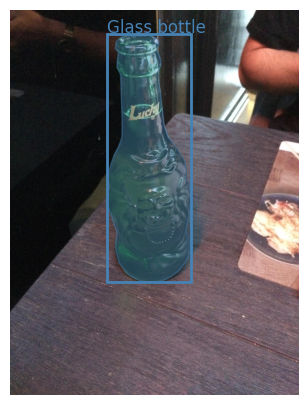

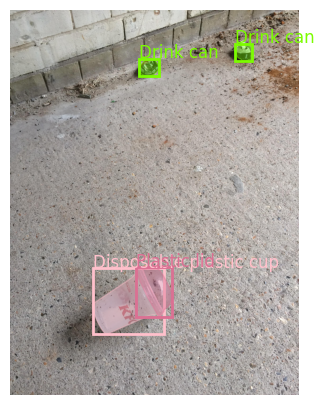

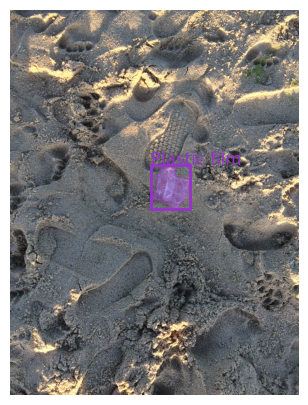

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import matplotlib.colors as mcolors

img_dir = '/content/drive/MyDrive/TACO'
ann_file = '/content/drive/MyDrive/TACO/annotations.json'

# Load COCO
coco = COCO(ann_file)

# Random color generator for each category
category_ids = coco.getCatIds()
colors = {
    cat_id: mcolors.to_rgb(random.choice(list(mcolors.CSS4_COLORS.values())))
    for cat_id in category_ids
}

# Pick random images
img_ids = coco.getImgIds()
random_ids = random.sample(img_ids, 3)

for img_id in random_ids:
    img_info = coco.loadImgs(img_id)[0]
    image_path = os.path.join(img_dir, img_info['file_name'])
    image = np.array(Image.open(image_path).convert("RGB"))

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    ax = plt.gca()

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        cat_id = ann['category_id']
        color = colors[cat_id]
        category_name = coco.loadCats(cat_id)[0]['name']

        # Draw bounding box
        bbox = ann['bbox']
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 5, category_name, color=color, fontsize=12)

        # Draw segmentation mask if available
        if 'segmentation' in ann:
            if isinstance(ann['segmentation'], list):
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((len(seg) // 2, 2))
                    patch = patches.Polygon(poly, linewidth=1,
                                            edgecolor=color,
                                            facecolor=color,
                                            alpha=0.4)
                    ax.add_patch(patch)
            elif isinstance(ann['segmentation'], dict):  # RLE
                rle = maskUtils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask = maskUtils.decode(rle)
                ax.imshow(mask, alpha=0.4, cmap='cool')

    plt.show()

This interactive visualization helps analyze the distribution of object **categories** and **supercategories** in the TACO dataset annotations. Looking at the distribution of annotations across categories and supercategories, we observe a significant class imbalance within the dataset. A small number of categories dominate the annotation count, while many others appear only a handful of times.
This imbalance is a key challenge in machine learning and highlights the need for few-shot learning techniques.

Few-shot learning helps models generalize better to rare categories, which are crucial in real-world applications like waste detection.

The K parameter in our visualization defines a minimum annotation threshold. Categories with counts above K are highlighted, while those below K are greyed out. Adjusting K helps focus on underrepresented categories, which is essential for addressing the challenges of few-shot learning.

- Try setting `K = 10` or `K = 30` to filter out common classes and focus on the rare ones.


In [ ]:
import json
from collections import Counter
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectionSlider
from pycocotools.coco import COCO

ann_file = '/content/drive/MyDrive/TACO/annotations.json'
coco = COCO(ann_file)

def plot_categories(K):
    cat_counts = {}
    supercat_counts = {}

    for ann in coco.anns.values():
        cat_id = ann['category_id']
        cat_info = coco.cats[cat_id]
        cat_name = cat_info['name']
        supercat = cat_info['supercategory']

        cat_counts[cat_name] = cat_counts.get(cat_name, 0) + 1
        supercat_counts[supercat] = supercat_counts.get(supercat, 0) + 1

    # Sort category counts
    sorted_cat = sorted(cat_counts.items(), key=lambda x: x[1], reverse=True)
    cat_names = [x[0] for x in sorted_cat]
    cat_values = [x[1] for x in sorted_cat]
    cat_colors = ['gray' if v <= K else 'skyblue' for v in cat_values]

    # Sort supercategory counts
    sorted_supercat = sorted(supercat_counts.items(), key=lambda x: x[1], reverse=True)
    supercat_names = [x[0] for x in sorted_supercat]
    supercat_values = [x[1] for x in sorted_supercat]
    supercat_colors = ['gray' if v <= K else 'orange' for v in supercat_values]

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    # Categories plot
    axs[0].barh(cat_names, cat_values, color=cat_colors)
    axs[0].set_title('Category Counts')
    axs[0].set_xlabel('Count')
    axs[0].invert_yaxis()

    for label, color in zip(axs[0].get_yticklabels(), cat_colors):
        label.set_color(color)

    # Supercategories plot
    axs[1].barh(supercat_names, supercat_values, color=supercat_colors)
    axs[1].set_title('Supercategory Counts')
    axs[1].set_xlabel('Count')
    axs[1].invert_yaxis()

    for label, color in zip(axs[1].get_yticklabels(), supercat_colors):
        label.set_color(color)

    plt.tight_layout()
    plt.show()

interact(
    plot_categories,
    K=SelectionSlider(
        options=[1, 2, 3, 5, 10, 30, 50, 100],
        value=10,
        description='K:',
        continuous_update=True
    )
)

loading annotations into memory...
Done (t=1.29s)
creating index...
index created!


interactive(children=(SelectionSlider(description='K:', index=4, options=(1, 2, 3, 5, 10, 30, 50, 100), value=…

<function __main__.plot_categories(K)>

# DeFRCN

In [ ]:
!cp -r /content/drive/MyDrive/FSOD.zip /content/
!unzip /content/FSOD.zip

Streaming output truncated to the last 5000 lines.
  inflating: FSOD/images/part_2/train_part_c/cd/cd13cd28dc4fddaa.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd1453ddc059be99.jpg  
 extracting: FSOD/images/part_2/train_part_c/cd/cd17a5bec47aa535.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd17ed129e96632d.jpg  
 extracting: FSOD/images/part_2/train_part_c/cd/cd1877b4cc2a7ae8.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd18f7623177b76b.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd1c67326add9de8.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd1e744d1dfc72d6.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd22e54c6b0020b6.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd233742a9cd6fbc.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd23756b6a8bc7b0.jpg  
  inflating: FSOD/images/part_2/train_part_c/cd/cd24cfd4a888753a.jpg  
 extracting: FSOD/images/part_2/train_part_c/cd/cd28010b0ab42566.jpg  
  inflating: FSOD/images/p

In [1]:
!pip install torchvision pycocotools opencv-python

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torchvision.transforms as T
import os
import numpy as np
from pycocotools.coco import COCO
import json
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import torch.nn as nn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
# ----- Cosine Classifier for DeFRCN -----
class CosineClassifier(torch.nn.Module):
    def __init__(self, num_classes, feature_dim):
        super().__init__()
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        # Initialize the prototype vectors for each class (learnable embeddings)
        self.prototypes = torch.nn.Parameter(torch.randn(num_classes, feature_dim))

    def forward(self, features):
        # Normalize the features and prototypes to unit vectors (this ensures cosine similarity)
        normalized_features = F.normalize(features, p=2, dim=-1)
        normalized_prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Compute cosine similarity between features and prototypes
        cosine_sim = torch.mm(normalized_features, normalized_prototypes.t())
        return cosine_sim

In [3]:
# ----- Gradient Scaler for DeFRCN -----
# This function scales the backward gradient during classification training
class GradientScaler(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, scale):
        ctx.scale = scale
        return input

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * ctx.scale, None

In [4]:
# ----- DeFRCN Model -----
# Wraps a Faster R-CNN model with DeFRCN-specific modifications
class DeFRCN(torch.nn.Module):
    def __init__(self, num_classes, grad_scale=0.1, use_cosine=False):
        super().__init__()
        # Set wether to use cosine head or not
        self.use_cosine = use_cosine
        # Load a pretrained Faster R-CNN model with ResNet-50 + FPN
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        for name, parameter in self.model.backbone.body.named_parameters():
            parameter.requires_grad = False

        # Replace the classification head with a new one for our custom dataset
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.bbox_regressor = nn.Linear(in_features, 4)

        self.grad_scale = grad_scale

        if use_cosine:
            self.classifier = CosineClassifier(num_classes, in_features)
        else:
            self.classifier = nn.Linear(in_features, num_classes)

        # Limit number of RPN proposals (important for stability)
        self.model.rpn.pre_nms_top_n_train = 200
        self.model.rpn.post_nms_top_n_train = 100
        self.model.rpn.pre_nms_top_n_test = 100
        self.model.rpn.post_nms_top_n_test = 50

    def forward(self, transformed_images, targets=None):

        features = self.model.backbone(transformed_images.tensors)

        # ---- STOP-GRADIENT from RPN to backbone ----
        features_detached = {k: v.detach() for k, v in features.items()}

        # RPN proposals using detached features
        proposals, proposal_losses = self.model.rpn(
            transformed_images, features_detached, targets if self.training else None
        )

        if self.training:
            # Match proposals to ground-truth and subsample them
            proposals, matched_idxs, labels, regression_targets = self.model.roi_heads.select_training_samples(
                proposals, targets
            )

            # ROI Align for subsampled proposals only
            box_features = self.model.roi_heads.box_roi_pool(features, proposals, transformed_images.image_sizes)
            box_features = self.model.roi_heads.box_head(box_features)

            # Classification head with gradient decoupling
            scaled_features = GradientScaler.apply(box_features, self.grad_scale)
            class_logits = self.classifier(scaled_features)


            # Regression head (no scaling)
            box_regression = self.bbox_regressor(box_features)

            # Flatten labels for loss
            labels = torch.cat(labels, dim=0)
            regression_targets = torch.cat(regression_targets, dim=0)

            # Classification loss
            loss_classifier = F.cross_entropy(class_logits, labels)

            # Regression loss only for foreground (label > 0)
            positive_inds = torch.where(labels > 0)[0]
            box_regression = box_regression[positive_inds]
            regression_targets = regression_targets[positive_inds]

            loss_box_reg = F.smooth_l1_loss(box_regression, regression_targets, reduction="sum") / (positive_inds.numel() + 1e-6)

            # Combine losses
            losses = {}
            losses.update(proposal_losses)
            losses.update({
                "loss_classifier": loss_classifier,
                "loss_box_reg": loss_box_reg
            })
            return losses

        else:
            # Inference: compute features from all proposals
            box_features = self.model.roi_heads.box_roi_pool(features, proposals, transformed_images.image_sizes)
            box_features = self.model.roi_heads.box_head(box_features)

            scaled_features = GradientScaler.apply(box_features, self.grad_scale)
            class_logits = self.cosine_classifier(scaled_features)
            box_regression = self.bbox_regressor(box_features)

            detections = self.model.roi_heads.postprocess_detections(
                class_logits, box_regression, proposals, transformed_images.image_sizes
            )
            return detections

In [5]:
# ----- TACO Dataset Loader -----
# Wraps COCO-style TACO dataset and formats annotations for training
class CocoWrapper(CocoDetection):
    def __init__(self, root, annFile, is_train=True, num_views=1, resize_size=(1024, 1024)):
        super().__init__(root, annFile)
        self.is_train = is_train
        self.num_views = num_views
        self.resize_size = resize_size
        self._init_transforms()

    def _init_transforms(self):
        import albumentations as A
        from albumentations.pytorch import ToTensorV2

        self.train_transform = A.Compose([
            A.Resize(*self.resize_size),
            A.VerticalFlip(p=0.5),  # Optional augmentation
            A.HorizontalFlip(p=0.5),
            A.Normalize(              # Normalize using ImageNet stats
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

        self.val_transform = A.Compose([
            A.Resize(*self.resize_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            if 'bbox' in ann:
                boxes.append(ann['bbox'])
                labels.append(ann['category_id'])

        img_np = np.array(img).astype(np.uint8)
        height, width = img_np.shape[:2]

        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        clipped_boxes = []
        for box in boxes:
            x, y, w, h = box
            x = np.clip(x, 0, width - 1)
            y = np.clip(y, 0, height - 1)
            w = max(1.0, min(w, width - x))
            h = max(1.0, min(h, height - y))
            clipped_boxes.append([x, y, w, h])

        transform = self.train_transform if self.is_train else self.val_transform

        images, targets = [], []
        for _ in range(self.num_views):
            transformed = transform(image=img_np, bboxes=clipped_boxes, category_ids=labels)

            img_tensor = transformed['image']
            boxes_tensor = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            labels_tensor = torch.tensor(transformed['category_ids'], dtype=torch.int64)

            if boxes_tensor.ndim == 1:
                boxes_tensor = boxes_tensor.unsqueeze(0)

            if boxes_tensor.numel() > 0:
                boxes_tensor[:, 2] += boxes_tensor[:, 0]
                boxes_tensor[:, 3] += boxes_tensor[:, 1]
                keep = (boxes_tensor[:, 2] > boxes_tensor[:, 0]) & (boxes_tensor[:, 3] > boxes_tensor[:, 1])
                boxes_tensor = boxes_tensor[keep]
                labels_tensor = labels_tensor[keep]

            if boxes_tensor.numel() == 0:
                boxes_tensor = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
                labels_tensor = torch.tensor([0], dtype=torch.int64)

            target = {
                "boxes": boxes_tensor,
                "labels": labels_tensor,
                "image_id": torch.tensor([img_id])
            }

            images.append(img_tensor)
            targets.append(target)

        return images, targets

# Custom collate function for batching

def collate_fn(batch):
    images, targets = zip(*batch)  # batch size × views
    images = [img for group in images for img in group]
    targets = [tgt for group in targets for tgt in group]
    return images, targets


In [6]:
import torchvision.ops as ops

def evaluate_map(model, dataset, device, iou_threshold=0.5):
    model.eval()
    all_precisions = []

    with torch.no_grad():
        for image, target in DataLoader(dataset, batch_size=1, shuffle=False):
            image = image[0].to(device)
            gt_boxes = target[0]['boxes'].to(device)
            gt_labels = target[0]['labels'].to(device)

            transformed_image, _ = model.model.transform([image])
            output = model(transformed_image)[0]
            pred_boxes = output['boxes']
            pred_labels = output['labels']
            scores = output['scores']

            if pred_boxes.size(0) == 0:
                all_precisions.append(0.0)
                continue

            ious = ops.box_iou(pred_boxes, gt_boxes)
            max_ious, matched_gt_idx = ious.max(dim=1)
            matches = max_ious >= iou_threshold
            correct = (pred_labels == gt_labels[matched_gt_idx]) & matches
            precision = correct.sum().item() / max(len(pred_boxes), 1)
            all_precisions.append(precision)

    model.train()
    return sum(all_precisions) / len(all_precisions)

In [7]:
# ----- Define Training Loop -----


def train_defrcn_general(
    model,
    dataset,
    device,
    num_epochs=10,
    batch_size=2,
    save_path=None,
    learning_rate=0.001,
    shuffle=True,
    resume_from_checkpoint=None,
    checkpoint_dir=None
):
    start_epoch = 0
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Resume from checkpoint
    if resume_from_checkpoint:
        checkpoint = torch.load('/content/drive/MyDrive/checkpoint_epoch_5.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from checkpoint: {resume_from_checkpoint} at epoch {start_epoch}")

    model.to(device)
    model.train()

    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=8,
        collate_fn=collate_fn
    )

    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0.0
        for batch_idx, (images, targets) in enumerate(data_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            transformed, _ = model.model.transform(images)
            losses = model(transformed, targets)
            loss = sum(loss for loss in losses.values())
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print(f"Epoch [{epoch + 1}/{num_epochs}] Batch [{batch_idx + 1}/{len(data_loader)}] Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

        # Save checkpoint
        if checkpoint_dir:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'use_cosine': model.use_cosine
            }, checkpoint_path)
            print(f"📦 Checkpoint saved at: {checkpoint_path}")

    # Final model save
    if save_path:
        torch.save({
            'model_state_dict': model.state_dict(),
            'use_cosine': model.use_cosine
        }, save_path)
        print(f"\n✅ Final model saved to: {save_path}")

In [8]:
# ----- GENERATE FEW_SHOTS -----
import json
import random
from collections import defaultdict
from pycocotools.coco import COCO

def sample_few_shot_coco(
    json_path,
    output_path,
    shots_per_category=5,
    target_categories=None,
    seed=42,
    strict=False
):
    random.seed(seed)

    # Load dataset
    coco = COCO(json_path)
    all_cats = coco.loadCats(coco.getCatIds())
    cat_id_to_name = {cat['id']: cat['name'] for cat in all_cats}
    cat_name_to_id = {cat['name']: cat['id'] for cat in all_cats}

    if target_categories is None:
        target_categories = [cat['name'] for cat in all_cats]

    target_cat_ids = [cat_name_to_id[name] for name in target_categories]

    # Count available instances
    available_instances = {
        cat_id: len(coco.getAnnIds(catIds=cat_id)) for cat_id in target_cat_ids
    }

    # Filter categories
    filtered_cat_ids = []
    for cat_id in target_cat_ids:
        if available_instances[cat_id] >= shots_per_category:
            filtered_cat_ids.append(cat_id)
        elif not strict:
            filtered_cat_ids.append(cat_id)
            print(f"[WARN] Category '{cat_id_to_name[cat_id]}' has only {available_instances[cat_id]} instances (requested: {shots_per_category})")
        else:
            print(f"[SKIP] Category '{cat_id_to_name[cat_id]}' skipped due to insufficient samples ({available_instances[cat_id]} < {shots_per_category})")

    # Sampling
    instance_counts = defaultdict(int)
    image_ids_collected = set()
    images_collected = {}
    annotations_collected = []
    image_ann_map = defaultdict(list)

    all_image_ids = list(coco.imgs.keys())
    random.shuffle(all_image_ids)

    for img_id in all_image_ids:
        if all(instance_counts[cat_id] >= min(shots_per_category, available_instances[cat_id]) for cat_id in filtered_cat_ids):
            break

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        selected_anns = []
        image_used = False

        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in filtered_cat_ids and instance_counts[cat_id] < shots_per_category:
                instance_counts[cat_id] += 1
                selected_anns.append(ann)
                image_used = True
            elif cat_id in filtered_cat_ids and not strict:
                # Accept extra annotations in relaxed mode
                selected_anns.append(ann)

        if image_used:
            image_info = coco.loadImgs(img_id)[0]
            images_collected[img_id] = image_info
            image_ids_collected.add(img_id)
            image_ann_map[img_id].extend(selected_anns)

    # Flatten annotations
    final_annotations = []
    for anns in image_ann_map.values():
        for ann in anns:
            if not strict or ann['category_id'] in filtered_cat_ids:
                final_annotations.append(ann)

    # Build remap
    sorted_cats = sorted([cat for cat in all_cats if cat['id'] in filtered_cat_ids], key=lambda c: c['id'])
    id_remap = {cat['id']: idx for idx, cat in enumerate(sorted_cats)}

    # Remap annotation category_ids
    for ann in final_annotations:
        ann['category_id'] = id_remap[ann['category_id']]

    # Remap category list
    remapped_categories = []
    for cat in sorted_cats:
        new_cat = cat.copy()
        new_cat['id'] = id_remap[cat['id']]
        remapped_categories.append(new_cat)

    # Final dataset
    few_shot_dataset = {
        "images": list(images_collected.values()),
        "annotations": final_annotations,
        "categories": remapped_categories
    }

    with open(output_path, 'w') as f:
        json.dump(few_shot_dataset, f, indent=2)

    # Print summary
    print(f"\n✅ Few-shot dataset saved to: {output_path}")
    print("📊 Instance counts per category (after remap):")
    for old_id, new_id in id_remap.items():
        name = cat_id_to_name[old_id]
        count = instance_counts[old_id]
        print(f"  [{new_id:2d}] {name:20s}: {count} / {shots_per_category}")

sample_few_shot_coco('/content/drive/MyDrive/TACO/annotations.json', '/content/drive/MyDrive/TACO/few_shot.json', shots_per_category=30, strict=True)

loading annotations into memory...
Done (t=1.60s)
creating index...
index created!
[SKIP] Category 'Battery' skipped due to insufficient samples (2 < 30)
[SKIP] Category 'Aluminium blister pack' skipped due to insufficient samples (6 < 30)
[SKIP] Category 'Carded blister pack' skipped due to insufficient samples (1 < 30)
[SKIP] Category 'Aerosol' skipped due to insufficient samples (10 < 30)
[SKIP] Category 'Toilet tube' skipped due to insufficient samples (5 < 30)
[SKIP] Category 'Egg carton' skipped due to insufficient samples (11 < 30)
[SKIP] Category 'Pizza box' skipped due to insufficient samples (3 < 30)
[SKIP] Category 'Foam cup' skipped due to insufficient samples (13 < 30)
[SKIP] Category 'Glass cup' skipped due to insufficient samples (6 < 30)
[SKIP] Category 'Other plastic cup' skipped due to insufficient samples (2 < 30)
[SKIP] Category 'Food waste' skipped due to insufficient samples (8 < 30)
[SKIP] Category 'Glass jar' skipped due to insufficient samples (6 < 30)
[SKIP] C

In [ ]:
# ----- NOVEL TRAINING -----

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_dataset = CocoWrapper(
    root='/content/drive/MyDrive/TACO/',
    annFile='/content/drive/MyDrive/TACO/few_shot.json',
    num_views=5
)

num_total_classes = len(full_dataset.coco.cats) + 1

model = DeFRCN(num_classes=num_total_classes, grad_scale=0.01, use_cosine=True).to(device)

train_defrcn_general(model, full_dataset, learning_rate=0.0005, num_epochs=100, batch_size=4, save_path='/content/drive/MyDrive/defrcn_finetune.pth', device=device)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpo

Epoch [1/100], Avg Loss: 5.2443
Epoch [2/100], Avg Loss: 5.1813
Epoch [3/100], Avg Loss: 5.1593
Epoch [4/100], Avg Loss: 5.2030
